In [1]:
import plotly.express as px
from IPython.display import display
from ingest_stocks_to_df import IngestStocks
from keras_stock_preprocessing import KerasPreprocess
from model_stock_fit import ModelFit
from model_stock_predict import ModelPredict
from visualize_stocks import VisualizeStocks
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd
from itertools import cycle
from keras.layers import Dense, GRU
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing import timeseries_dataset_from_array
from keras.utils import model_to_dot, plot_model

# data

date  GSIT                                            ICAD  \
                       High    Low  Open Close  Volume Adj Close       High   
Date                                                                          
2020-03-03 2020-03-03  6.85  6.540  6.63  6.63   46800      6.63  12.680000   
2020-03-04 2020-03-04  6.77  6.570  6.63  6.73   73500      6.73  14.340000   
2020-03-05 2020-03-05  7.03  6.650  6.65  6.79   31000      6.79  15.310000   
2020-03-06 2020-03-06  6.82  6.560  6.72  6.65   29100      6.65  14.500000   
2020-03-09 2020-03-09  6.47  5.940  6.47  6.17   56400      6.17  13.840000   
...               ...   ...    ...   ...   ...     ...       ...        ...   
2021-02-25 2021-02-25  7.79  7.460  7.61  7.64  142600      7.64  18.879999   
2021-02-26 2021-02-26  7.77  7.340  7.76  7.34   72700      7.34  19.160000   
2021-03-01 2021-03-01  7.77  7.440  7.46  7.67  117000      7.67  19.250000   
2021-03-02 2021-03-02  7.78  7.530  7.61  7.65   62600      7.65  19.379999   
2021-03-03 2021-03-03  7.95  7.535  7.82  7.81   81452      7.81  21.000000   

                                  ...       ARKF                        \
                  Low       Open  ...       Open      Close     Volume   
Date                              ...                                    
2020-03-03  12.260000  12.680000  ...  25.299999  24.580000    44200.0   
2020-03-04  12.660000  12.660000  ...  24.840000  25.230000    65000.0   
2020-03-05  13.530000  14.030000  ...  24.730000  24.503000    35500.0   
2020-03-06  12.790000  13.500000  ...  23.940001  24.040001    62000.0   
2020-03-09  12.610000  13.620000  ...  22.500000  22.230000    68200.0   
...               ...        ...  ...        ...        ...        ...   
2021-02-25  16.450001  18.879999  ...  57.459999  54.970001  6191200.0   
2021-02-26  17.700001  18.150000  ...  54.889999  55.279999  4845600.0   
2021-03-01  18.389999  18.969999  ...  57.169998  57.860001  3968700.0   
2021-03-02  18.389999  18.799999  ...  58.400002  57.080002  2874600.0   
2021-03-03  19.110001  19.379999  ...  57.080002  54.520000  3727155.0   

                             ARKW                                      \
            Adj Close        High         Low        Open       Close   
Date                                                                    
2020-03-03  24.487818   66.150002   62.340000   65.589996   63.439999   
2020-03-04  25.135380   65.239998   63.500000   64.620003   65.199997   
2020-03-05  24.411108   65.110001   63.240002   63.720001   63.779999   
2020-03-06  23.949844   62.514999   60.540001   61.869999   61.860001   
2020-03-09  22.146631   58.790001   55.369999   56.240002   56.779999   
...               ...         ...         ...         ...         ...   
2021-02-25  54.970001  171.509995  158.919998  168.910004  160.259995   
2021-02-26  55.279999  163.559998  155.949997  161.020004  160.889999   
2021-03-01  57.860001  168.449997  164.104004  166.000000  168.330002   
2021-03-02  57.080002  170.479996  164.389999  170.179993  164.389999   
2021-03-03  54.520000  165.849899  155.710098  165.169998  156.149994   

                                   
               Volume   Adj Close  
Date                               
2020-03-03   410800.0   62.627037  
2020-03-04   174700.0   64.364479  
2020-03-05   177900.0   62.962681  
2020-03-06   258400.0   61.067287  
2020-03-09   295200.0   56.052383  
...               ...         ...  
2021-02-25  3383600.0  160.259995  
2021-02-26  2701300.0  160.889999  
2021-03-01  2441300.0  168.330002  
2021-03-02  1590800.0  164.389999  
2021-03-03  2774074.0  156.149994  

[253 rows x 43 columns]

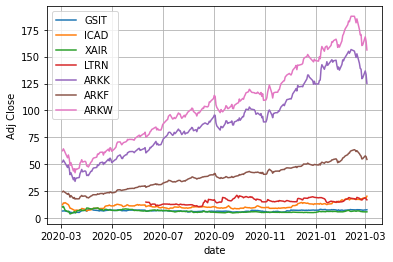

In [9]:
stocks_str = 'GSIT, ICAD, XAIR, LTRN, ARKK, ARKF, ARKW'
ticker_list = [ticker.strip() for ticker in stocks_str.upper().split(',')]
stock_names = ticker_list[0:3]
time_diff_years= 1
column_metric = 'Adj Close'
company_name = 'GSIT'
lookback_length=40
batch_size=30
latest_day=-lookback_length
future_num_days=30
mf = ModelFit
# model=mf.gru_model()
# model=mf.lstm_dense_model()
# model=mf.stack_3_lstm_model()
model=mf.bi_stack_lstm_model()


file_name = IngestStocks.get_file_name(ticker_list=ticker_list, time_diff_years=time_diff_years)
stocks_df = pd.read_pickle(file_name)
# stocks_df = IngestStocks.ingest_stocks_to_df(ticker_list=ticker_list, time_diff_years=time_diff_years)
display(stocks_df)
plot = VisualizeStocks.add_stocks_fig(stock_names=ticker_list, column_metric=column_metric,stocks_df=stocks_df)

# fit

In [10]:
def main(model=None):
    train_ds, val_ds, test_ds = KerasPreprocess.keras_batch_preprocess(stocks_df=stocks_df, company_name=company_name, metric=column_metric, lookback_length=lookback_length, batch_size=batch_size)
    history, model = mf.train_model(train_data=train_ds, validation_data=val_ds, model=model)
    test_error = ModelPredict.evaluate_model(model, test_ds)
    train_error = pd.DataFrame(history.history)
    prediction_data = KerasPreprocess.get_prediction_data(stocks_df=stocks_df, company_name=company_name, metric=column_metric, lookback_length=lookback_length, latest_day=latest_day)
    predictions = ModelPredict.pred_next_days(future_num_days=future_num_days, previous_days=prediction_data, model=model)
    ax = VisualizeStocks.plot_future(predictions=predictions, stocks_df=stocks_df, latest_day=latest_day, future_num_days=future_num_days, company_name=company_name, column_metric=column_metric)
    return ax, train_error, test_error

Epoch 1/300
4/4 [==============================] - 2s 191ms/step - loss: 15.5069 - mse: 15.5069 - val_loss: 1.5146 - val_mse: 1.5146
Epoch 2/300
4/4 [==============================] - 0s 65ms/step - loss: 0.9679 - mse: 0.9679 - val_loss: 4.3033 - val_mse: 4.3033
Epoch 3/300
4/4 [==============================] - 0s 57ms/step - loss: 0.8896 - mse: 0.8896 - val_loss: 1.1856 - val_mse: 1.1856
Epoch 4/300
4/4 [==============================] - 0s 60ms/step - loss: 0.1117 - mse: 0.1117 - val_loss: 0.1814 - val_mse: 0.1814
Epoch 5/300
4/4 [==============================] - 0s 59ms/step - loss: 0.6044 - mse: 0.6044 - val_loss: 0.1375 - val_mse: 0.1375
Epoch 6/300
4/4 [==============================] - 0s 60ms/step - loss: 0.6406 - mse: 0.6406 - val_loss: 0.4430 - val_mse: 0.4430
Epoch 7/300
4/4 [==============================] - 0s 58ms/step - loss: 0.3355 - mse: 0.3355 - val_loss: 0.9649 - val_mse: 0.9649
Epoch 8/300
4/4 [==============================] - 0s 57ms/step - loss: 0.2172 - mse: 0

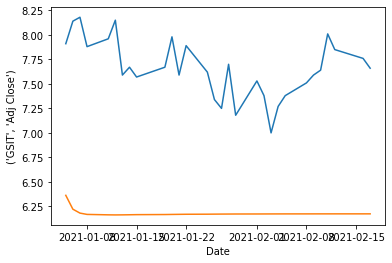

In [11]:
ax, train_error, test_error = main()

,loss,mse,val_loss,val_mse
0,11.690889,11.690889,1.514628,1.514628
1,1.401968,1.401968,4.303307,4.303307
2,1.044225,1.044225,1.185572,1.185572
3,0.103375,0.103375,0.181363,0.181363
4,0.455382,0.455382,0.137452,0.137452
5,0.468650,0.468650,0.443036,0.443036
6,0.281608,0.281608,0.964906,0.964906
7,0.252893,0.252893,1.100552,1.100552
8,0.214667,0.214667,0.836926,0.836926
9,0.174905,0.174905,0.560469,0.560469


1.5487838983535767

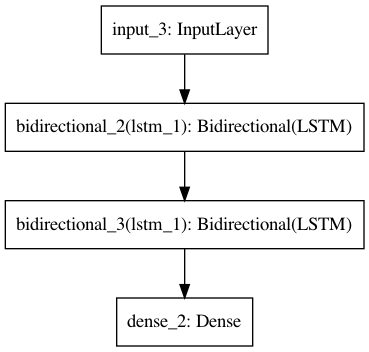

In [12]:
display(train_error)
display(test_error)
display(plot_model(model, expand_nested=True))
plt.show()

In [17]:
ax = ax
plt.show()